In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

In [112]:
# Wczytanie plików z danymi
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=column_names)
ratings.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [113]:
movies = pd.read_csv("Movie_Id_Titles")
movies.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [124]:
df = pd.merge(ratings,movies,on='item_id')
df.drop('timestamp',axis=1,inplace=True)
df.head(10)

,user_id,item_id,rating,title
0,0,50,5,Star Wars (1977)
1,290,50,5,Star Wars (1977)
2,79,50,4,Star Wars (1977)
3,2,50,5,Star Wars (1977)
4,8,50,5,Star Wars (1977)
5,274,50,5,Star Wars (1977)
6,227,50,4,Star Wars (1977)
7,99,50,5,Star Wars (1977)
8,305,50,5,Star Wars (1977)
9,108,50,4,Star Wars (1977)


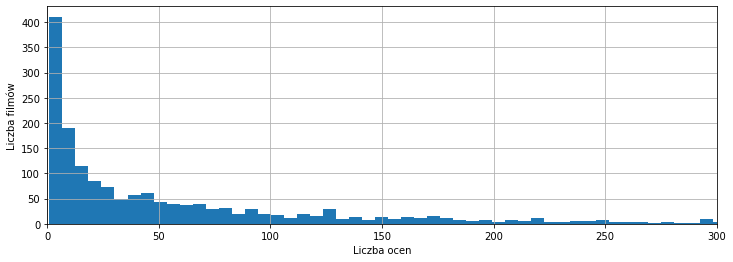

In [131]:
ratings_overall = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_overall['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
plt.figure(figsize=(12,4))
ratings_overall['num of ratings'].hist(bins=100)
plt.xlim(0,300)
plt.xlabel("Liczba ocen")
plt.ylabel("Liczba filmów")
#plt.savefig(fname="histo",dpi=400)

In [115]:
# Sprawdzenie ile jest niepowtarzalnych użytkowników i filmów
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 944
Num of Movies: 1682


In [25]:
#Utworzenie macierzy user-item
user_item_matrix = np.zeros((n_users, n_items))

for line in df.itertuples():
    user_item_matrix[line[1]-1, line[2]-1] = line[3]

In [95]:
# Wyliczenie macierzy podobieństwa cosinusowego
user_similarity = pairwise_distances(user_item_matrix, metric='cosine')
user_similarity

array([[0.        , 0.83306902, 0.95254046, ..., 0.82049212, 0.60182526,
        0.88011184],
       [0.83306902, 0.        , 0.88940868, ..., 0.82773219, 0.89420212,
        0.88445968],
       [0.95254046, 0.88940868, 0.        , ..., 0.86658385, 0.97344413,
        1.        ],
       ...,
       [0.82049212, 0.82773219, 0.86658385, ..., 0.        , 0.81753534,
        0.81819143],
       [0.60182526, 0.89420212, 0.97344413, ..., 0.81753534, 0.        ,
        0.88109606],
       [0.88011184, 0.88445968, 1.        , ..., 0.81819143, 0.88109606,
        0.        ]])

In [33]:
# Funkcja przewidująca 
def predict(ratings, similarity):
    mean_user_rating = ratings.mean(axis=1)
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

In [34]:
# tablica z wartościami przewidzianymi dla wszystkich uzytkownikow
user_prediction = predict(user_item_matrix, user_similarity)

In [97]:
user_ids = list(df.user_id.unique())
user_rec_df = pd.DataFrame(user_prediction, columns = movies["title"], index = user_ids)
user_rec_df

title,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
0,2.063487,0.734109,0.629859,1.010133,0.640608,0.476275,1.783076,1.162308,1.512193,0.704320,...,0.394268,0.394660,0.394208,0.393200,0.393571,0.392500,0.395135,0.393817,0.393276,0.392999
290,1.761190,0.383745,0.196102,0.730839,0.225532,0.004039,1.492013,0.875286,1.107330,0.261838,...,-0.086690,-0.085240,-0.086884,-0.087904,-0.087045,-0.089033,-0.087215,-0.088124,-0.086666,-0.086460
79,1.793833,0.328750,0.158737,0.683427,0.173169,-0.035478,1.486531,0.834859,1.134153,0.236197,...,-0.134532,-0.133274,-0.135278,-0.136173,-0.134778,-0.137344,-0.136108,-0.136726,-0.134705,-0.134501
2,1.728256,0.293671,0.127667,0.644335,0.142055,-0.062142,1.435611,0.795499,1.095609,0.211630,...,-0.161194,-0.160002,-0.161322,-0.162366,-0.161415,-0.163655,-0.162063,-0.162859,-0.161223,-0.161029
8,1.795012,0.454297,0.354355,0.762618,0.359466,0.196092,1.546003,0.908232,1.290938,0.437796,...,0.101970,0.102612,0.102131,0.101048,0.101919,0.100161,0.102722,0.101441,0.101284,0.101409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,1.820464,0.418885,0.286345,0.715018,0.294348,0.106758,1.513069,0.852302,1.194155,0.359089,...,0.014293,0.014920,0.014356,0.013294,0.013903,0.012213,0.014298,0.013256,0.013873,0.014030
358,1.589609,0.274987,0.102126,0.623670,0.133655,-0.069410,1.319163,0.764642,1.033869,0.192516,...,-0.165917,-0.164720,-0.166016,-0.167129,-0.166417,-0.168221,-0.165955,-0.167088,-0.166312,-0.166151
410,1.808672,0.404578,0.275365,0.726059,0.281224,0.087180,1.548891,0.849371,1.204687,0.342831,...,-0.008150,-0.007546,-0.008014,-0.009005,-0.008021,-0.009925,-0.007798,-0.008861,-0.008254,-0.007837
598,1.836674,0.479478,0.384904,0.779999,0.388378,0.241107,1.562795,0.945988,1.288748,0.487204,...,0.147245,0.148425,0.147411,0.146419,0.147135,0.145760,0.148411,0.147086,0.146518,0.146634


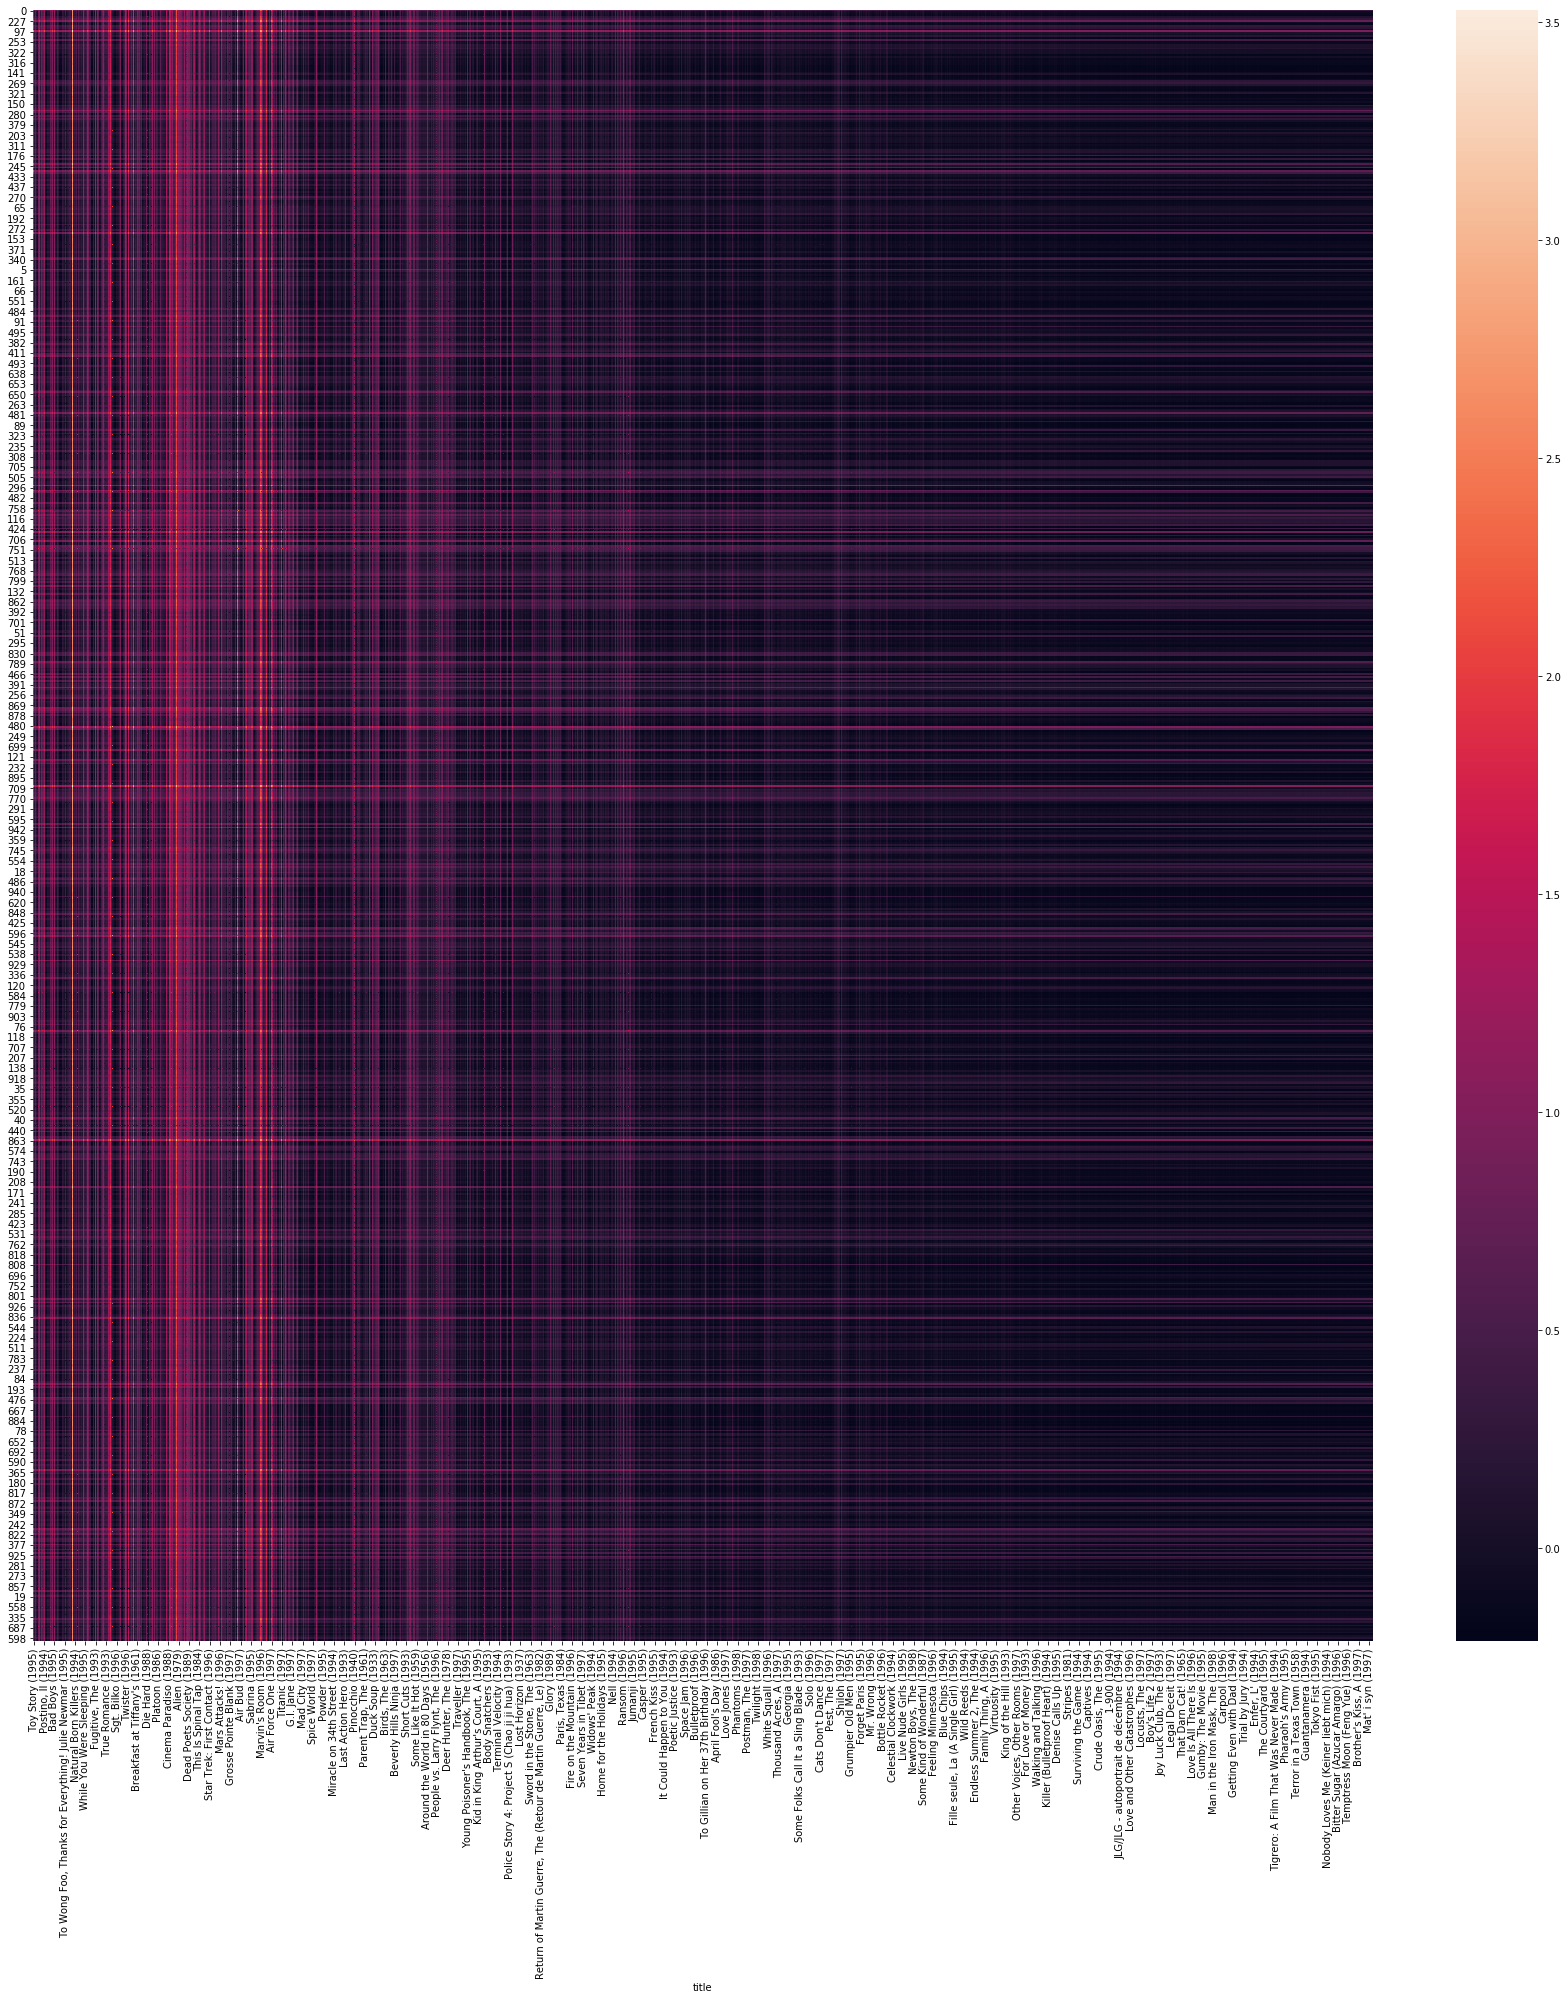

In [123]:
plt.figure(figsize=(30,30))
sns.heatmap(user_rec_df)
#plt.savefig(fname="heatmap",dpi=400)

In [162]:
# Rekomendacja 5 najbardziej pasujących filmów dla użytkownika o podanym id
def recommend_top5(data):
    user = int(input("Enter the user id to whom you want to recommend: "))
    print("The Recommendations for user Id : ",user)
    print("\n")
    
    rec = list(user_rec_df.iloc[user].sort_values(ascending=False).head(20).to_frame().index.values)
    for i in range(20):
        print(rec[i])

In [164]:
recommend_top5(user_rec_df)

Enter the user id to whom you want to recommend: 355
The Recommendations for user Id :  355


Star Wars (1977)
Fargo (1996)
Return of the Jedi (1983)
Raiders of the Lost Ark (1981)
Godfather, The (1972)
Toy Story (1995)
Contact (1997)
Silence of the Lambs, The (1991)
Pulp Fiction (1994)
English Patient, The (1996)
Empire Strikes Back, The (1980)
Twelve Monkeys (1995)
Scream (1996)
Independence Day (ID4) (1996)
Jerry Maguire (1996)
Liar Liar (1997)
Fugitive, The (1993)
Princess Bride, The (1987)
Rock, The (1996)
Back to the Future (1985)
